# 非线性支持向量机SVM

这里在iris数据集实现高斯核

高斯核:

$$K(x_{1}, x_{2}) = e^{\left(-\gamma \cdot (x_{1} - x_{2})^{2}\right)}$$

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn import datasets
from tensorflow.python.framework import ops
ops.reset_default_graph()

/home/zhangxin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
sess = tf.Session()

### 加载Iris数据集

我们的x值是$(x_1, x_2)$

$x_1 =$ 'Sepal Length'

$x_2 =$ 'Petal Width'

目标值标记数据点是否是Iris Setosa。

In [3]:
# 加载数据
# iris.data = [(Sepal Length, Sepal Width, Petal Length, Petal Width)]
iris = datasets.load_iris()
x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals = np.array([1 if y==0 else -1 for y in iris.target])
class1_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==1]
class1_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==1]
class2_x = [x[0] for i,x in enumerate(x_vals) if y_vals[i]==-1]
class2_y = [x[1] for i,x in enumerate(x_vals) if y_vals[i]==-1]

### 模型参数

我们需要声明

- 批尺寸大小
- 占位符
- SVM核的拟合b值

注意我们创建separate占位符，向prediction grid喂数据，这么做是为了方便画图展示。

In [4]:
# 批尺寸大小
batch_size = 150

# 初始化占位符
x_data = tf.placeholder(shape=[None, 2], dtype=tf.float32)
y_target = tf.placeholder(shape=[None, 1], dtype=tf.float32)
prediction_grid = tf.placeholder(shape=[None, 2], dtype=tf.float32)

# 创建SVM需要的变量
b = tf.Variable(tf.random_normal(shape=[1,batch_size]))

### 高斯核（RBF）

我们创建高斯核。该核可用于将数据点转换为更高维的空间。

两点的核，$x$和$x'$被给出为

$$K(x, x')=exp\left(-\gamma|| x-x' ||^{2}\right)$$

对于$\gamma$非常小的情况，核是非常宽的。对于大的$\gamma$则情况相反。这意味着大的$\gamma$对应这高偏差和小方差模型。

如果我们有一个点向量，$x$的尺寸为（batch_size, 2），然后我们的核计算可以变为：

$$
K(\mathbf{x})=exp\left( -\gamma \mathbf{x} \cdot \mathbf{x}^{T} \right)
$$

In [5]:
# 高斯核（RBF）
gamma = tf.constant(-50.0)
sq_vec = tf.multiply(2., tf.matmul(x_data, tf.transpose(x_data)))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_vec)))

### 计算SVM模型

这里，SVM损失由两项计算得到。第一项是$b$矩阵的和，以及第二项是

$$
\sum\left(K\cdot||\mathbf{b}||^{2}||\mathbf{y}||^{2}\right)
$$

我们最终使用TensorFlow，通过最小化负值来最大化损失：

$$-\left(\sum\mathbf{b} - \sum\left(K\cdot||\mathbf{b}||^{2}||\mathbf{y}||^{2}\right)\right)$$

In [6]:
# 计算SVM模型
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = tf.matmul(y_target, tf.transpose(y_target))
second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)))
loss = tf.negative(tf.subtract(first_term, second_term))

### 定义预测核

In [7]:
# 高斯（RBF）预测核
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1),[-1,1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1),[-1,1])
pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2., tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(tf.transpose(y_target),b), pred_kernel)
prediction = tf.sign(prediction_output-tf.reduce_mean(prediction_output))
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.squeeze(prediction), tf.squeeze(y_target)), tf.float32))

### 优化方法

我们声明梯度下降法和初始化模型变量（`b`）

In [8]:
# 优化器
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

# 初始化变量
init = tf.global_variables_initializer()
sess.run(init)

### 运行分类器

进行300轮训练，每75轮打印损失值，用来观察训练过程。

In [9]:
# 训练
loss_vec = []
batch_accuracy = []
for i in range(300):
    rand_index = np.random.choice(len(x_vals), size=batch_size)
    rand_x = x_vals[rand_index]
    rand_y = np.transpose([y_vals[rand_index]])
    sess.run(train_step, feed_dict={x_data: rand_x, y_target: rand_y})
    
    temp_loss = sess.run(loss, feed_dict={x_data: rand_x, y_target: rand_y})
    loss_vec.append(temp_loss)
    
    acc_temp = sess.run(accuracy, feed_dict={x_data: rand_x,
                                             y_target: rand_y,
                                             prediction_grid:rand_x})
    batch_accuracy.append(acc_temp)
    
    if (i+1)%75==0:
        print('Step #' + str(i+1))
        print('Loss = ' + str(temp_loss))

Step #75
Loss = -114.377945
Step #150
Loss = -226.87785
Step #225
Loss = -339.3778
Step #300
Loss = -451.8779


### 打印结果

In [10]:
# 画图
x_min, x_max = x_vals[:, 0].min() - 1, x_vals[:, 0].max() + 1
y_min, y_max = x_vals[:, 1].min() - 1, x_vals[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02),
                     np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]
[grid_predictions] = sess.run(prediction, feed_dict={x_data: x_vals,
                                                   y_target: np.transpose([y_vals]),
                                                   prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

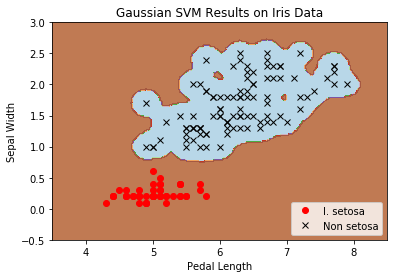

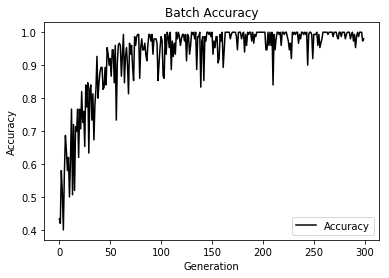

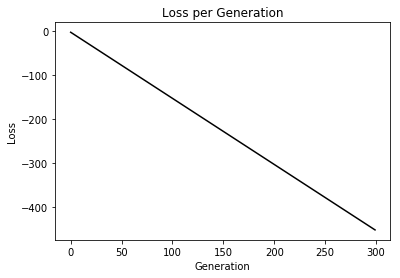

In [11]:
%matplotlib inline
plt.contourf(xx, yy, grid_predictions, cmap=plt.cm.Paired, alpha=0.8)
plt.plot(class1_x, class1_y, 'ro', label='I. setosa')
plt.plot(class2_x, class2_y, 'kx', label='Non setosa')
plt.title('Gaussian SVM Results on Iris Data')
plt.xlabel('Pedal Length')
plt.ylabel('Sepal Width')
plt.legend(loc='lower right')
plt.ylim([-0.5, 3.0])
plt.xlim([3.5, 8.5])
plt.show()

plt.plot(batch_accuracy, 'k-', label='Accuracy')
plt.title('Batch Accuracy')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.plot(loss_vec, 'k-')
plt.title('Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Loss')
plt.show()

### 评估测试点

In [12]:
x_test_seq = np.array([4., 5., 6., 7.])
y_test_seq = np.array([0., 1., 2.])

x_test, y_test = np.meshgrid(x_test_seq,y_test_seq)
test_points = np.c_[x_test.ravel(), y_test.ravel()]

In [13]:
test_points

array([[4., 0.],
       [5., 0.],
       [6., 0.],
       [7., 0.],
       [4., 1.],
       [5., 1.],
       [6., 1.],
       [7., 1.],
       [4., 2.],
       [5., 2.],
       [6., 2.],
       [7., 2.]])

In [15]:
test_predictions.ravel()

NameError: name 'test_predictions' is not defined

Format the test points together with the predictions:

In [31]:
for ix, point in enumerate(test_points):
    point_pred = test_predictions.ravel()[ix]
    print('Point {} is predicted to be in class {}'.format(point, point_pred))

Point [4. 0.] is predicted to be in class 1.0
Point [5. 0.] is predicted to be in class 1.0
Point [6. 0.] is predicted to be in class 1.0
Point [7. 0.] is predicted to be in class 1.0
Point [4. 1.] is predicted to be in class 1.0
Point [5. 1.] is predicted to be in class -1.0
Point [6. 1.] is predicted to be in class -1.0
Point [7. 1.] is predicted to be in class 1.0
Point [4. 2.] is predicted to be in class 1.0
Point [5. 2.] is predicted to be in class 1.0
Point [6. 2.] is predicted to be in class -1.0
Point [7. 2.] is predicted to be in class -1.0
